In [1]:
import pandas as pd
import os
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import numpy as np
import geopandas as gpd
from shapely import wkt
import contextily as ctx
from IPython.display import Image, display

/Users/Administrator/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
def plot_points(df):
    df_unique = df.drop_duplicates(subset='geometry').copy()

    #convert to GeoDataFrame
    df_unique[['lon', 'lat']] = df_unique['geometry'].str.extract(r'POINT \(([^ ]+) ([^ ]+)\)').astype(float)
    gdf = gpd.GeoDataFrame(
        df_unique,
        geometry=gpd.points_from_xy(df_unique['lon'], df_unique['lat']),
        crs="EPSG:4326"
    )

    # NL map
    fig, ax = plt.subplots(figsize=(10, 10))
    gdf.to_crs(epsg=3857).plot(ax=ax, color='red', markersize=5, alpha=0.7)  # Web Mercator
    ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
    ax.set_title("Unique Wells in Netherlands")
    plt.show()

def count_points_by_filter(df, plot_histogram=True):
    df = df.copy()

    # Convert 'Date' to datetime
    if not pd.api.types.is_datetime64_any_dtype(df['Date']):
        df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

    # filter only years >= 2000
    df_filtered = df[df['Date'].dt.year >= 2000]

    counts = df_filtered.groupby('Filter').size()

    if plot_histogram:
        counts.plot(kind='bar')
        plt.xlabel('Filter Number')
        plt.ylabel('Number of Data Points')
        plt.title('Data Points per Filter (after 2000)')
        plt.xticks(rotation=0)
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout()
        plt.show()

    return counts.to_dict()

def plot_timeseries_for_well(df, well_id):
    df = df.copy()

    df_filtered = df[
        (df['Well_ID'] == well_id) &
        (df['Filter'] == 1)
    ]

    if df_filtered.empty:
        print(f"No data found for Well_ID {well_id} with Filter 1.")
        return

    df_filtered = df_filtered.sort_values('Date')

    plt.figure(figsize=(10, 5))
    plt.plot(df_filtered['Date'], df_filtered['Depth'], marker='o', linestyle='-')

    plt.ylim(-4.75, -3) 

    plt.title(f"Groundwater Depth over Time for Well {well_id} (Filter 1)")
    plt.xlabel("Date")
    plt.ylabel("Waterstand (meter t.o.v. NAP)")
    plt.grid(True)
    plt.show()


## Flevoland

In [3]:
province = "flevoland"
variable = "depth"

current_dir = os.getcwd()
base_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))
path = os.path.join(base_dir, f'data/raw/well_{variable}_data/{province}_well_{variable}_combined.csv')

In [4]:
df = pd.read_csv(path)

In [5]:
df['Date'] = pd.to_datetime(df['Date'], errors='coerce', utc=True)

In [6]:
print(f"Total number of data points: {len(df)}")

Total number of data points: 30291661


Check for missing values across all columns

In [7]:
df.isna().sum()

Well_ID               0
BRO-ID                0
Filter                0
Date                137
Depth            185053
geometry              0
Ground Level      49869
Bottom Screen         0
Top Screen            0
dtype: int64

In [16]:
df[df['Date'].isna()]

,Well_ID,BRO-ID,Filter,Date,Depth,geometry,Ground Level,Bottom Screen,Top Screen
5554461,GMW000000037690,GLD000000011171,1,NaT,-0.08,POINT (5.773439025 52.629534337),0.30,-13.5,-12.5
5554462,GMW000000037690,GLD000000011171,1,NaT,0.07,POINT (5.773439025 52.629534337),0.30,-13.5,-12.5
5554463,GMW000000037690,GLD000000011171,1,NaT,-0.08,POINT (5.773439025 52.629534337),0.30,-13.5,-12.5
5554464,GMW000000037690,GLD000000011171,1,NaT,-0.06,POINT (5.773439025 52.629534337),0.30,-13.5,-12.5
5554465,GMW000000037690,GLD000000011171,1,NaT,-0.14,POINT (5.773439025 52.629534337),0.30,-13.5,-12.5
...,...,...,...,...,...,...,...,...,...
5566893,GMW000000037720,GLD000000011603,6,NaT,-0.32,POINT (5.776344747 52.657474692),1.75,-17.0,-16.0
5566900,GMW000000037720,GLD000000011603,6,NaT,-0.26,POINT (5.776344747 52.657474692),1.75,-17.0,-16.0
5566901,GMW000000037720,GLD000000011603,6,NaT,-0.19,POINT (5.776344747 52.657474692),1.75,-17.0,-16.0
5566902,GMW000000037720,GLD000000011603,6,NaT,-0.34,POINT (5.776344747 52.657474692),1.75,-17.0,-16.0


Find which year is the most represented

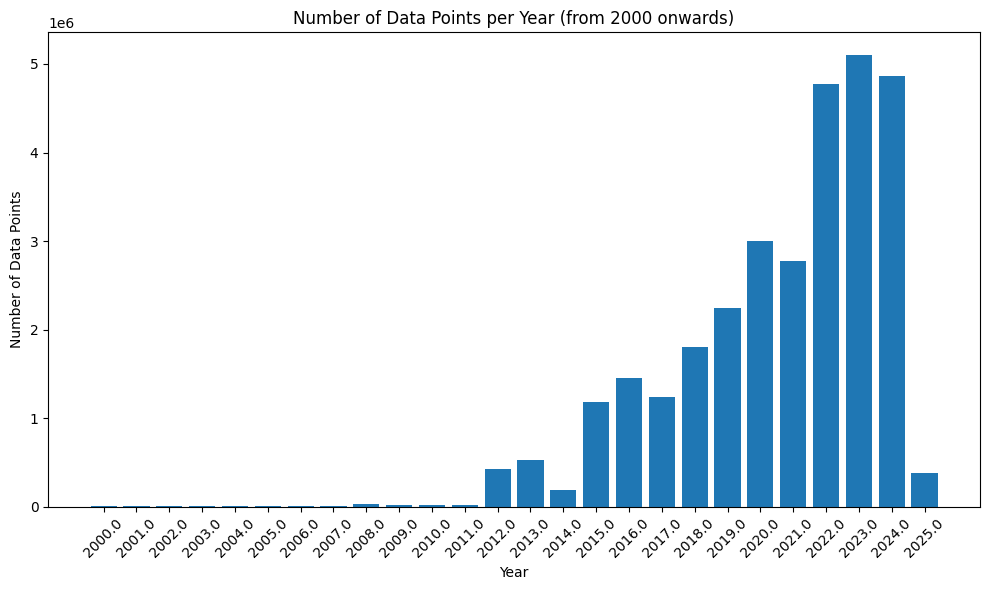

In [13]:
df_year = pd.DataFrame({'Year': df['Date'].dt.year})

df_filtered = df_year[df_year['Year'] >= 2000]

# Count data points per year
year_counts = df_filtered['Year'].value_counts().sort_index()

# Plot
plt.figure(figsize=(10, 6))
plt.bar(year_counts.index.astype(str), year_counts.values)
plt.xlabel("Year")
plt.ylabel("Number of Data Points")
plt.title("Number of Data Points per Year (from 2000 onwards)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [12]:
year_counts.head(100)

,Year,Count
0,1935.0,43
1,1936.0,36
2,1937.0,25
3,1938.0,41
4,1939.0,35
...,...,...
84,2021.0,2770004
85,2022.0,4774781
86,2023.0,5102489
87,2024.0,4865309


Drop rows with missing "Depth" values

In [131]:
df_no_nan.isna().sum()

Well_ID              0
BRO-ID               0
Filter               0
Date                 0
Depth                0
geometry             0
Ground Level     31400
Bottom Screen        0
Top Screen           0
dtype: int64

In [79]:
len(df_no_nan)

5859068

In [18]:
df_after_2000 = df[df['Date'].dt.year >= 2000]

In [133]:
df_after_2000.isna().sum()

Well_ID              0
BRO-ID               0
Filter               0
Date                 0
Depth            15767
geometry             0
Ground Level     31400
Bottom Screen        0
Top Screen           0
dtype: int64

In [ ]:
df_after_2000 = df.dropna(subset=['Depth'])
df_after_2000 = df_after_2000.dropna(subset=['Date'])

In [81]:
print(f"Number of data points after year 2000: {len(df_after_2000)}")

Number of data points after year 2000: 5775988


In [25]:
filtered_df = df_after_2000[df_after_2000['Filter'] == 0]
filtered_df

,Well_ID,BRO-ID,Filter,Date,Depth,geometry,Ground Level,Bottom Screen,Top Screen
16194070,GMW000000057155,GLD000000067080,0,2022-01-24 11:00:54+00:00,-5.286,POINT (5.435237737 52.486779939),-4.84,-9.64,-8.64
16194071,GMW000000057155,GLD000000067080,0,2022-01-24 11:01:54+00:00,-5.298,POINT (5.435237737 52.486779939),-4.84,-9.64,-8.64
16194072,GMW000000057155,GLD000000067080,0,2022-01-24 11:02:55+00:00,-5.303,POINT (5.435237737 52.486779939),-4.84,-9.64,-8.64
16194073,GMW000000057155,GLD000000067080,0,2022-01-24 11:03:56+00:00,-5.313,POINT (5.435237737 52.486779939),-4.84,-9.64,-8.64
16194074,GMW000000057155,GLD000000067080,0,2022-01-24 11:04:57+00:00,-5.319,POINT (5.435237737 52.486779939),-4.84,-9.64,-8.64
...,...,...,...,...,...,...,...,...,...
22561280,GMW000000057160,GLD000000067085,0,2023-07-27 05:00:00+00:00,-5.652,POINT (5.454801934 52.474965086),-4.50,-9.20,-8.20
22561281,GMW000000057160,GLD000000067085,0,2023-07-27 06:00:00+00:00,-5.643,POINT (5.454801934 52.474965086),-4.50,-9.20,-8.20
22561282,GMW000000057160,GLD000000067085,0,2023-07-27 07:00:00+00:00,-5.641,POINT (5.454801934 52.474965086),-4.50,-9.20,-8.20
22561283,GMW000000057160,GLD000000067085,0,2023-07-27 08:00:00+00:00,-5.636,POINT (5.454801934 52.474965086),-4.50,-9.20,-8.20


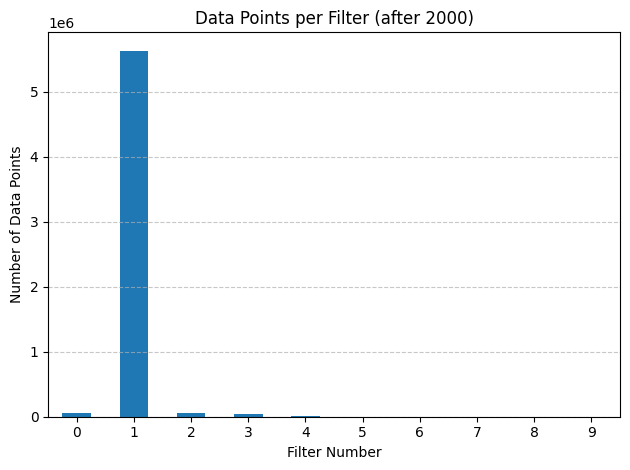

{0: 50000, 1: 5634783, 2: 54532, 3: 40193, 4: 4915, 5: 2206, 6: 2211, 7: 1797, 8: 1064, 9: 54}


In [84]:
counts = count_points_by_filter(df)
print(counts)

In [86]:
n_unique_wells = df_after_2000['Well_ID'].nunique()
print(f"Number of unique wells: {n_unique_wells}")

Number of unique wells: 1048


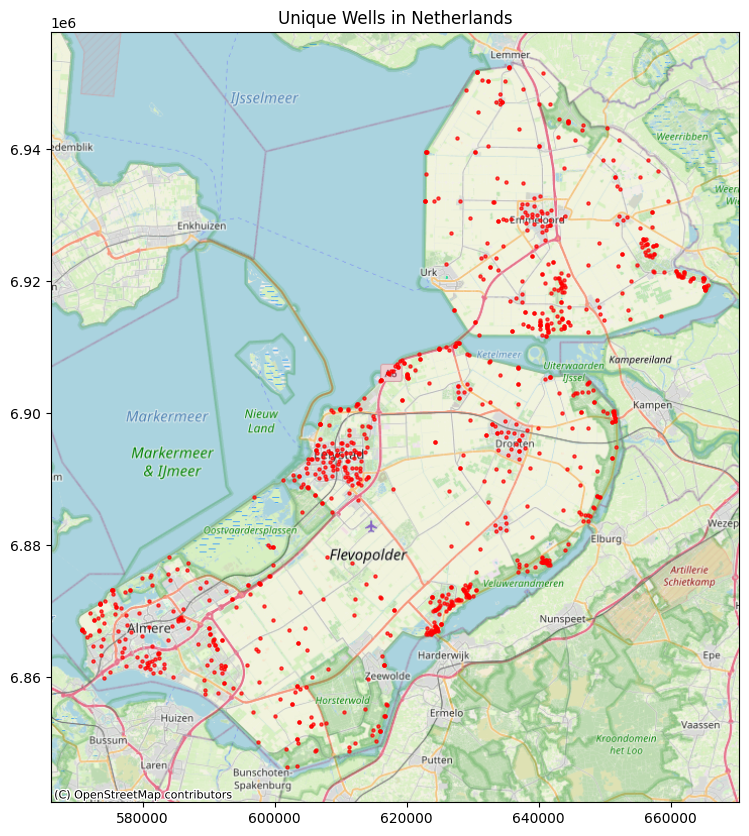

In [85]:
plot_points(df_after_2000)

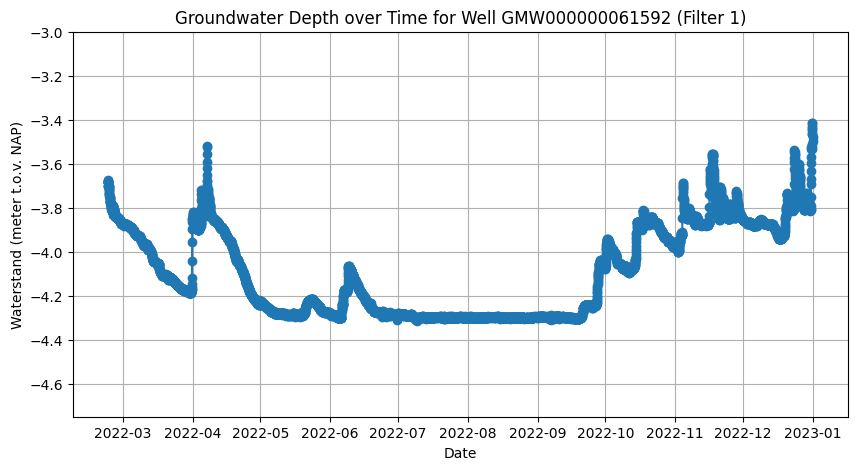

In [130]:
plot_timeseries_for_well(df_after_2000, "GMW000000061592")

## Utrecht

In [52]:
province = "utrecht"
variable = "depth"

current_dir = os.getcwd()
base_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))
path = os.path.join(base_dir, f'data/raw/well_{variable}_data/{province}_well_{variable}_combined.csv')

In [53]:
df = pd.read_csv(path)

In [54]:
df['Date'] = pd.to_datetime(df['Date'], errors='coerce', utc=True)

In [55]:
print(f"Total number of data points: {len(df)}")

Total number of data points: 30200376


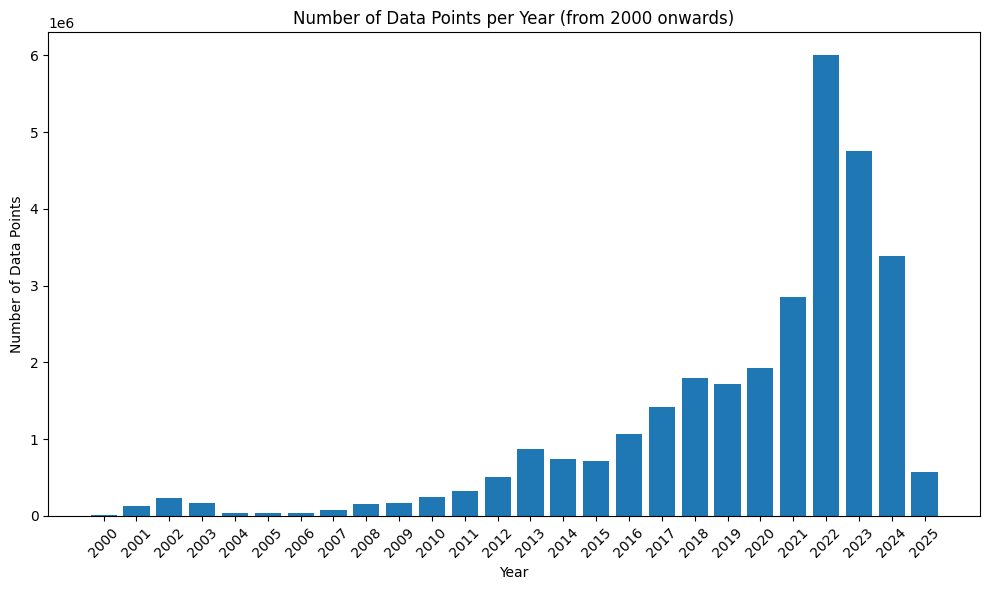

In [56]:
df_year = pd.DataFrame({'Year': df['Date'].dt.year})

df_filtered = df_year[df_year['Year'] >= 2000]

# Count data points per year
year_counts = df_filtered['Year'].value_counts().sort_index()

# Plot
plt.figure(figsize=(10, 6))
plt.bar(year_counts.index.astype(str), year_counts.values)
plt.xlabel("Year")
plt.ylabel("Number of Data Points")
plt.title("Number of Data Points per Year (from 2000 onwards)")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [58]:
df_after_2000 = df[df['Date'].dt.year >= 2000]

In [59]:
df_after_2000 = df.dropna(subset=['Depth'])
df_after_2000 = df_after_2000.dropna(subset=['Date'])

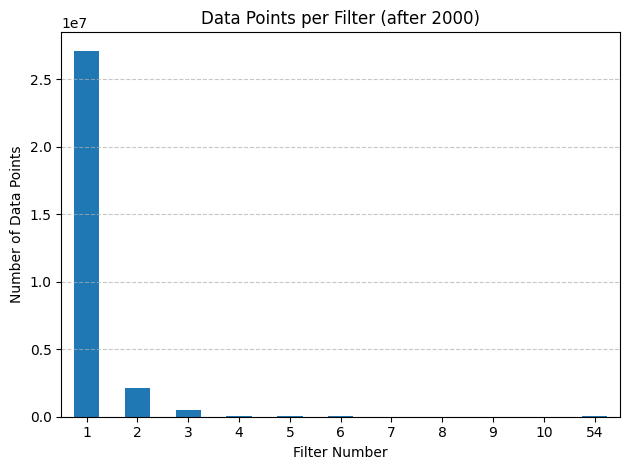

{1: 27115250, 2: 2149695, 3: 474710, 4: 66645, 5: 28447, 6: 18918, 7: 10133, 8: 349, 9: 515, 10: 335, 54: 36196}


In [60]:
counts = count_points_by_filter(df_after_2000)
print(counts)

In [61]:
n_unique_wells = df_after_2000['Well_ID'].nunique()
print(f"Number of unique wells: {n_unique_wells}")

Number of unique wells: 1078


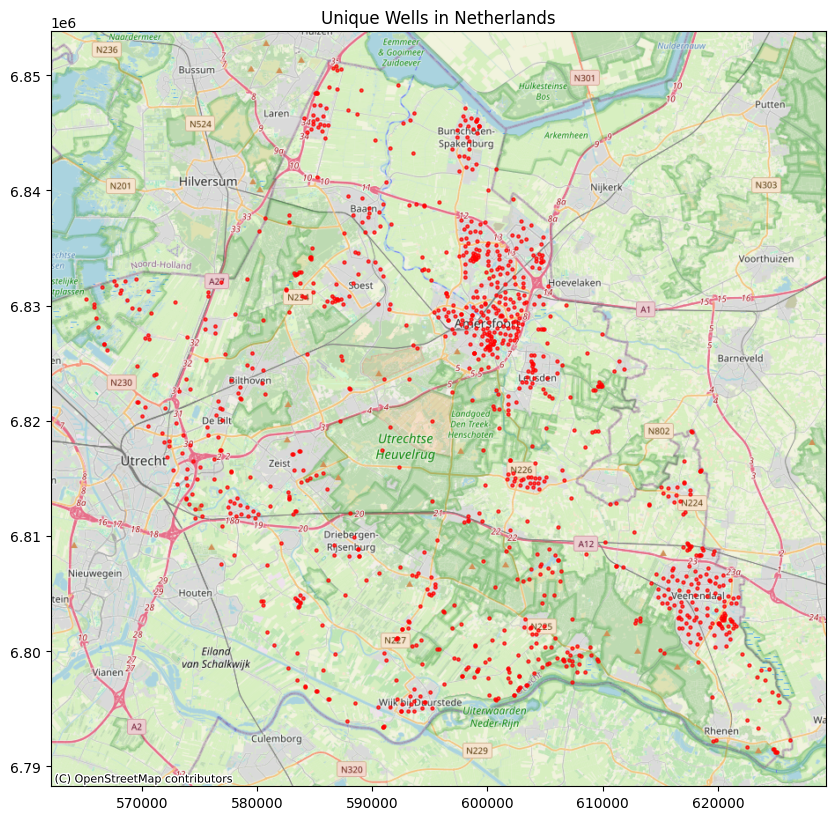

In [62]:
plot_points(df_after_2000)